In [7]:
"""
Generate model KBOs orbits from a distribution function and determine if any are detected by a given survey.
"""
from ossssim.models import Resonant, DetectFile
from ossssim import definitions, plotter, ModelFile, ModelOutputFile
from ossssim import OSSSSim
import os
import matplotlib as mpl
from astropy.table import Table
from astropy import units
import rebound
# This installation has no fonts, if working on a local device you might set your font here.
mpl.rcParams['font.family'] = []
mpl.rcParams['font.serif'] = []



def run(model, ssim, model_file, detect_file, n_track):
    """
    Using the ParametricModel defined here run the survey simulator and save detected sources to detect_filename

    Args:
        model_file (ModelFile): A ModelFile object to store the generated model in
        ssim (OSSSSim) :  A survey simulator object that describes the characterization of the survey 
        detect_filename (DetectFile): A DetectFile object to store the detected sources to
        characterization_directory (str): Relative or absolute path to directory on disk where the characterization files are organized
        seed (int): random number seed, specifying allows reproducibility
        n_track (int): < 0 continue for ntrack iterations;
                      > 0 continue until n_tracked tracked detections;
                      = 0 continue until input exhausted
    """

    n_iter = n_tracked = n_hits = 0
    for row in model:
        n_iter += 1
        model_file.write_row(row)
        result = ssim.simulate(row, epoch=model.epoch, seed=model.seed, colors=model.colors, model_band=model.model_band)
        if result['flag'] > 0:
            n_hits += 1
            detect_file.write_row(result)
        if result['flag'] > 2:
            n_tracked += 1
        if (0 < n_track < n_tracked) or (0 < -n_track < n_iter):
            break

In [2]:
!LS

/usr/bin/sh: 1: LS: not found


In [2]:
seed = 123446789
characterization_directory = 'Surveys/CFEPS'
model_filename = 'PlutinoModel.dat'
detection_filename = 'PlutinoDetection.dat'
ssim = OSSSSim(characterization_directory=characterization_directory)
if os.access(model_filename, os.F_OK):
    os.remove(model_filename)
if os.access(detection_filename, os.F_OK):
    os.remove(detection_filename)

# the default Resonant class arguments setup for a Plutino model....
model = Resonant(j=4, k=1, seed=seed, comp='plutino_implanted', size=100)
model_file = ModelOutputFile(filename=model_filename,  epoch=model.epoch, colors=model.colors,
                       longitude_neptune=model.longitude_neptune)
detect_file = DetectFile(filename=detection_filename,  epoch=model.epoch, colors=model.colors,
                       longitude_neptune=model.longitude_neptune)
run(model, ssim, model_file, detect_file, n_track=-5000)

/opt/SSim/python/ossssim/plotter.py:143: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.ax1.set_xticklabels(x_tick_labels, color='b', alpha=0.6)


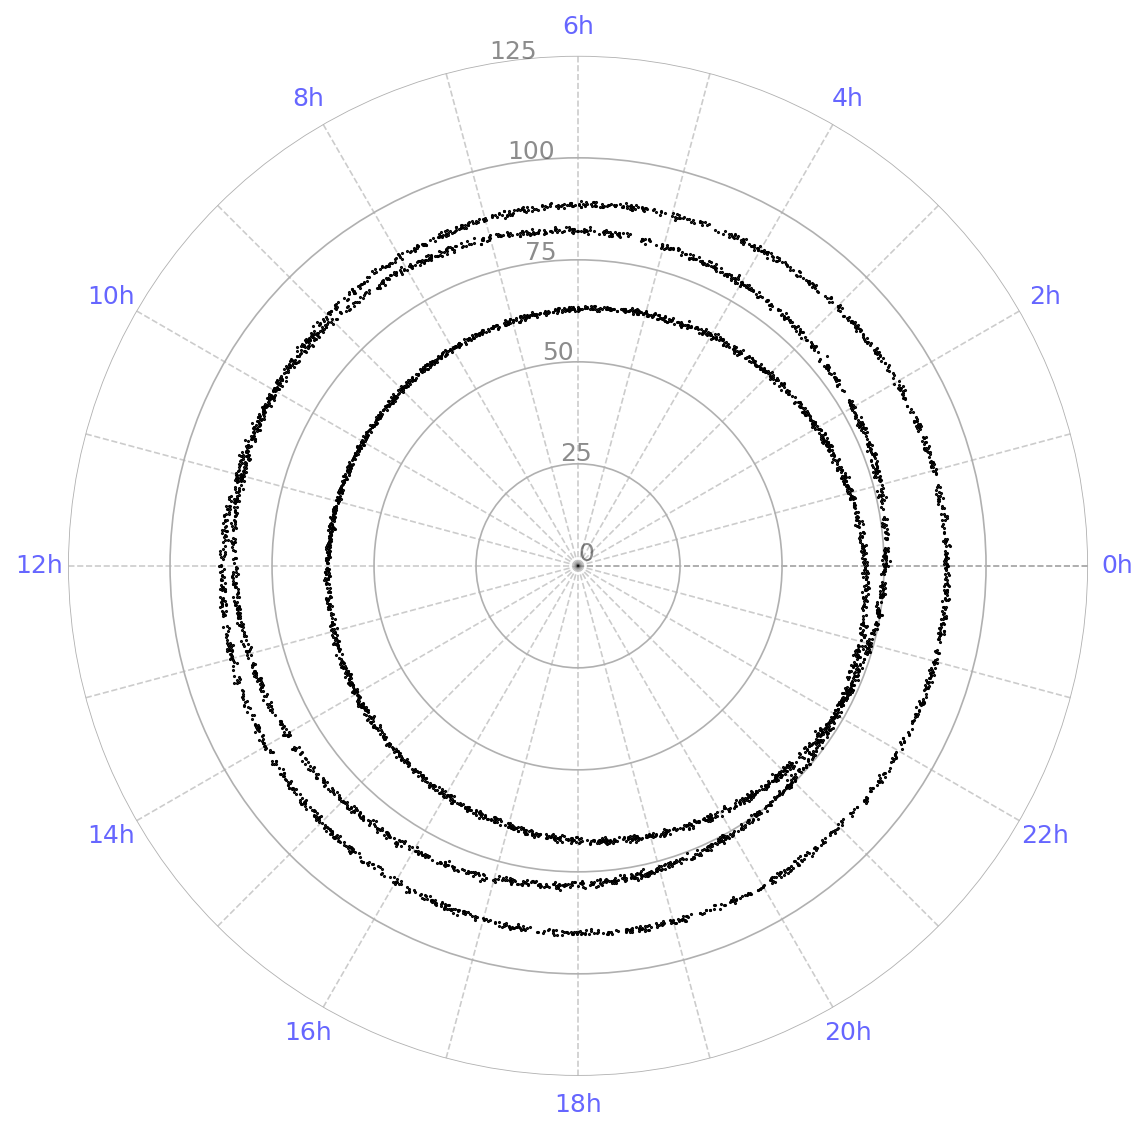

In [8]:

def face_down_plot(model_filename: str, detection_filename: str) -> None:
    """_
    Plot the detected objects in a face-down plot
    Args:
        detect_file: name of file with the detected sources
    """
    plot = plotter.RosePlot(definitions.Neptune['Longitude'], outer_edge=125*units.au)
    #plot.add_model(ModelFile(detection_filename), ms=5, mc='g')
    plot.add_model(ModelFile(model_filename), mc='k', ms=1, alpha=1)
    # plot.plot_rings()
    plot.show()
model_filename = 'PlutinoModel.dat'
detection_filename = 'PlutinoDetection.dat'

face_down_plot(model_filename, detection_filename)

In [ ]:
from matplotlib import pyplot
from astropy.table import Table
from astropy.coordinates import SkyCoord
ms = 1
alpha = 1
mc = {'PlutinoDetection.dat': 'g', 'PlutinoModel.dat': 'k'}
ms = {'PlutinoDetection.dat': 5, 'PlutinoModel.dat': 1}
fig = pyplot.figure(figsize=(8, 8))
rect = [0.0725, 0.0725, 0.85, 0.85]  # the plot occupies not all the figure space
ax1 = fig.add_axes(rect, polar=True, frameon=False) 
for name in ['PlutinoModel.dat', 'PlutinoModel.dat']:
    print(name)
    d = Table.read(name, format='ascii.ecsv')
    d['coord'] = SkyCoord(d['x'], d['y'], d['z'], representation_type='cartesian',
                          frame='heliocentrictrueecliptic', obstime='2000-01-01').transform_to('heliocentrictrueecliptic')
    
    ax1.plot(d['coord'].lon.to('rad').value,
              d['coord'].distance.to('au').value,
              f'.{mc[name]}',
              markersize=ms[name],
              alpha=alpha)
    print(name, d['coord'].distance.min())
    print(name, d['coord'].distance.max())
    print(((d['x']**2 + d['y']**2 + d['z']**2)**0.5).max())

In [ ]:
import matplotlib as mpl
from matplotlib import pyplot
from ossssim import plotter, ModelFile, definitions
from astropy import units
# This installation has no fonts, if working on a local device you might set your font here.
mpl.rcParams['font.family'] = []
mpl.rcParams['font.serif'] = []
name = 'PlutinoModel.dat'
d = Table.read(name, format='ascii.ecsv')
# ((self.phi - self.j * self.M + self.k * (self.longitude_neptune - self.node)) / self.k) % (360 * units.deg)
phi = (d['peri']*d['k'] + d['j']*d['M'] - d['k']*(d.meta['Longitude_Neptune'] - d['node'])) % (360 * units.deg)
x = pyplot.hist(phi, bins=100, histtype='step', cumulative=True)

In [ ]:
import numpy
from ossssim.models import Resonant
from astropy import units
from matplotlib import pyplot
model = Resonant(j=3, k=2, seed=123456789, comp='plutino_implanted', size=100)
# model_file = ModelFile('PlutinoModel.dat')
# model = model_file
peri = model.peri
j=3
k=2
M = model.M
node = model.node
long_nep = model.header['Longitude_Neptune']
phi1 = numpy.array((peri*k + j*M - k*(long_nep - node)) % (360 * units.deg))
print("--")
peri = model.table['peri']
M = model.table['M']
node = model.table['node']
phi2 = numpy.array((peri*k + j*M - k*(long_nep - node)) % (360 * units.deg))
x = pyplot.hist(phi1, histtype='step', cumulative=True)
x = pyplot.hist(phi2, histtype='step', cumulative=True)
#x = pyplot.hist(model.phi, histtype='step', cumulative=True)


In [ ]:
import rebound
from astropy.table import Table
name = 'PlutinoModel.dat'
d = Table.read(name, format='ascii.ecsv')

In [ ]:
_sim = rebound.Simulation()
rebound.data.add_outer_solar_system(_sim)
#_sim.add("Sun")
#_sim.add("Jupiter")
#_sim.add("Saturn")
#_sim.add("Uranus")
#_sim.add("Neptune")
#_sim.move_to_com()
print(_sim.t)
for i in range(len(d['a'])):
    _sim.add(a=d['a'].to('au').value[i], 
             e=d['e'][i], 
             inc=d['inc'].to('rad').value[i], 
             Omega=d['node'].to('rad').value[i], 
             omega=d['peri'].to('rad').value[i], 
             M=d['M'].to('rad').value[i])

In [ ]:
from matplotlib import pyplot
import matplotlib as mpl
# This installation has no fonts, if working on a local device you might set your font here.
mpl.rcParams['font.family'] = []
mpl.rcParams['font.serif'] = []
x = [ p.__getattribute__('x') for p in _sim.particles[5:]]
y = [ p.__getattribute__('y') for p in _sim.particles[5:]]
pyplot.plot(x, y, '.')
pyplot.plot(d['x'], d['y'], '.b')

In [ ]:
from astropy.table import Table
row = {'one': [1,], 'two': [2,]}
Table(row)

In [ ]:
_sim = rebound.Simulation()
rebound.data.add_outer_solar_system(_sim)
_sim.move_to_com()
ps = [_sim.add(**dict(row)) for row in model_file.table['a','e','inc','omega','Omega','M'] ]
_sim.add(ps)
import numpy as np
a = np.zeros((_sim.N,6))
_sim.serialize_particle_data(xyzvxvyvz=a)


In [ ]:
ps

In [ ]:
_sim.particles[1]

In [ ]:
model_file.table[1:10]